In [1]:
!pip install -q 'tensorflow-text==2.15.*'
!pip index versions tensorflow-text

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-decision-forests 1.9.1 requires tensorflow~=2.16.1, but you have tensorflow 2.15.1 which is incompatible.
tensorflow-decision-forests 1.9.1 requires tf-keras~=2.16, but you have tf-keras 2.15.1 which is incompatible.
tensorflow-serving-api 2.16.1 requires tensorflow<3,>=2.16.1, but you have tensorflow 2.15.1 which is incompatible.
tensorflow-text (2.17.0)
Available versions: 2.17.0, 2.16.1, 2.15.0, 2.14.0, 2.13.0, 2.12.1, 2.12.0, 2.11.0, 2.10.0, 2.9.0, 2.8.2, 2.8.1
  INSTALLED: 2.15.0
  LATEST:    2.17.0


In [2]:
import string
import numpy as np
import pandas as pd
from numpy import array
from pickle import load

from PIL import Image
import pickle
from collections import Counter
import matplotlib.pyplot as plt

import sys, time, os, warnings
warnings.filterwarnings("ignore")
import re

import keras
import tensorflow as tf
from tqdm import tqdm
from nltk.translate.bleu_score import sentence_bleu

from keras.utils import pad_sequences
from keras.utils import load_img
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense, BatchNormalization
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Dropout
from keras.layers import add
from keras.callbacks import ModelCheckpoint
from keras.utils import img_to_array
#from keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.applications.convnext import ConvNeXtTiny, preprocess_input


from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

2024-08-22 14:39:31.697439: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-22 14:39:31.697515: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-22 14:39:31.698953: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
image_path = "/kaggle/input/flickr8k/Images"
data = pd.read_csv("/kaggle/input/bancap/BAN-Cap_captiondata.csv")
jpgs = os.listdir(image_path)
print("Total Images in Dataset = {}".format(len(jpgs)))
print(type(data))
data

Total Images in Dataset = 8091
<class 'pandas.core.frame.DataFrame'>


caption_id  \
0      1000268201_693b08cb0e.jpg#0   
1      1000268201_693b08cb0e.jpg#1   
2      1000268201_693b08cb0e.jpg#2   
3      1000268201_693b08cb0e.jpg#3   
4      1000268201_693b08cb0e.jpg#4   
...                            ...   
40450   997722733_0cb5439472.jpg#0   
40451   997722733_0cb5439472.jpg#1   
40452   997722733_0cb5439472.jpg#2   
40453   997722733_0cb5439472.jpg#3   
40454   997722733_0cb5439472.jpg#4   

                                         english_caption  \
0      A child in a pink dress is climbing up a set o...   
1                  A girl going into a wooden building .   
2       A little girl climbing into a wooden playhouse .   
3      A little girl climbing the stairs to her playh...   
4      A little girl in a pink dress going into a woo...   
...                                                  ...   
40450           A man in a pink shirt climbs a rock face   
40451           A man is rock climbing high in the air .   
40452  A person in a red shirt climbing up a rock fac...   
40453                    A rock climber in a red shirt .   
40454  A rock climber practices on a rock climbing wa...   

                                         bengali_caption  
0      একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1                 একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2                   একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3               ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4      গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...  
...                                                  ...  
40450     গোলাপী শার্টের একটি লোক একটি শিলার উপরে উঠেছিল  
40451                    একজন মানুষ পাথরে চড়ছে অনেক উপরে  
40452  লাল শার্টের একজন ব্যক্তি সহায়তার হাতলগুলিতে ঢ...  
40453                           লাল শার্টে একটি রক আরোহী  
40454  একটি রক আরোহী একটি শৈল আরোহণ প্রাচীর এর উপর অন...  

[40455 rows x 3 columns]

In [4]:
data['caption_id']=data['caption_id'].str[:-2]
data=data.drop('english_caption',axis=1)
data.rename(columns = {'caption_id':'filename','bengali_caption':'caption'}, inplace = True)
uni_filenames = np.unique(data.filename.values)
data.head()

filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1             একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2               একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3           ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4  গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...

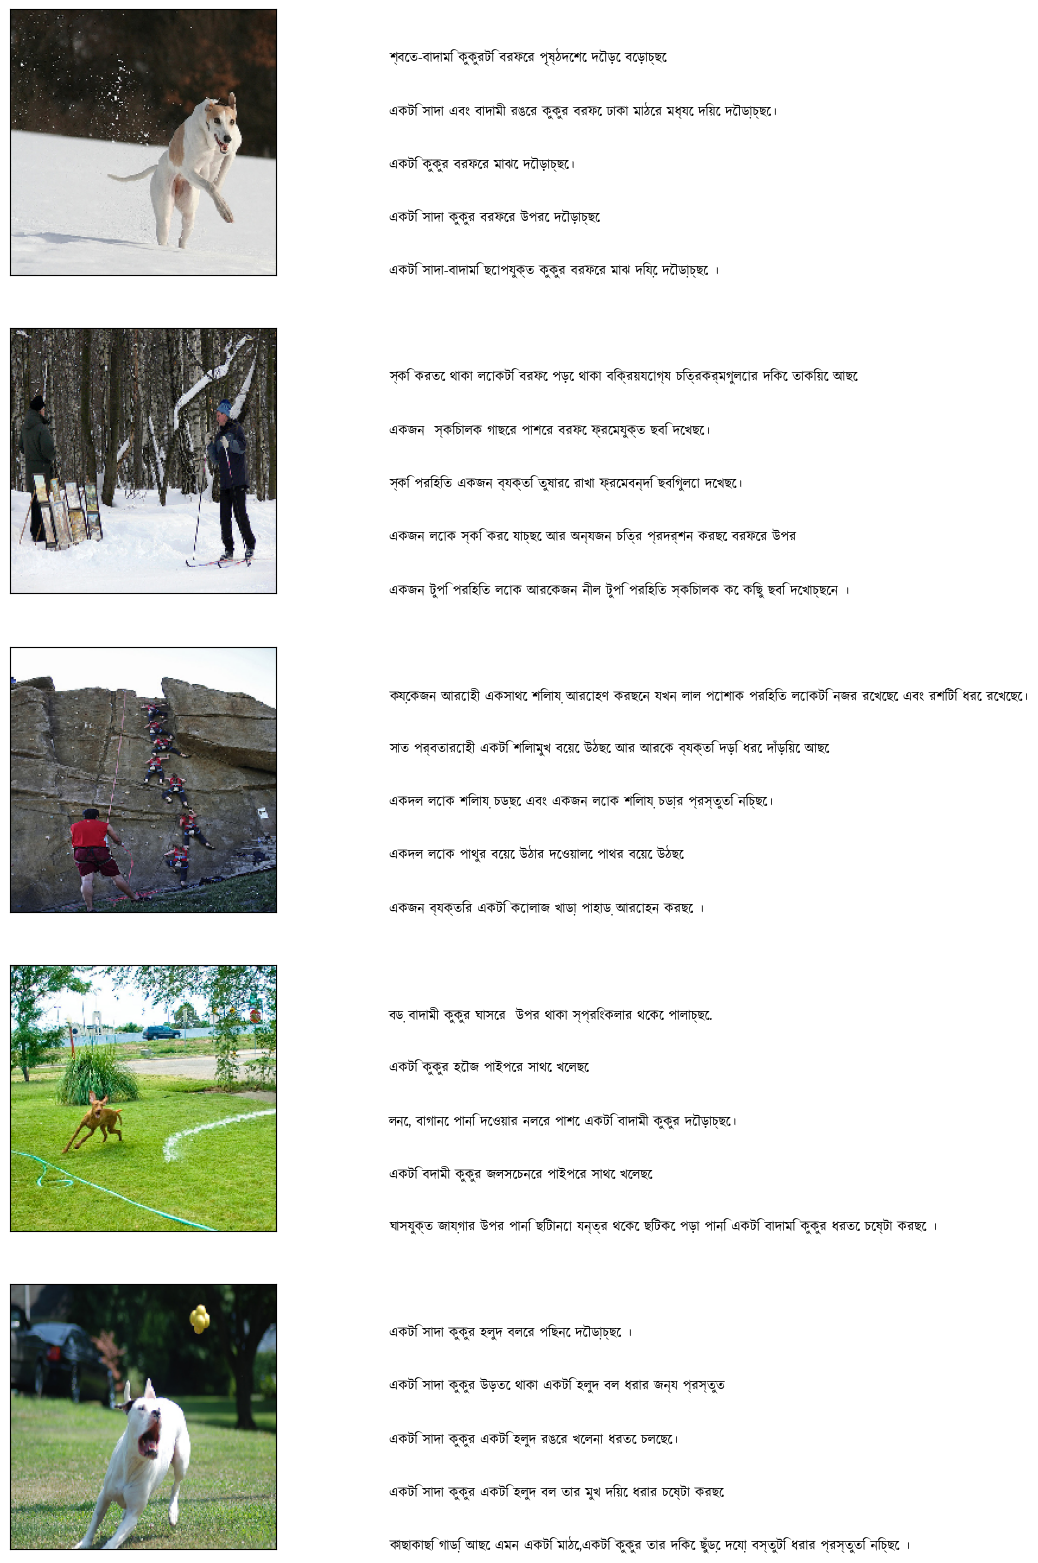

In [5]:
from matplotlib import font_manager
bangla_font_path = "/kaggle/input/kalpurush/kalpurush.ttf"  # Provide the path to your installed Bangla font
bangla_font_prop = font_manager.FontProperties(fname=bangla_font_path)
npic = 5
npix = 224
target_size = (npix,npix,3)
count = 1

fig = plt.figure(figsize=(10,20))
for jpgfnm in uni_filenames[10:15]:
    filename = image_path + '/' + jpgfnm
    captions = list(data["caption"].loc[data["filename"]==jpgfnm].values)
    image_load = load_img(filename, target_size=target_size)
    ax = fig.add_subplot(npic,2,count,xticks=[],yticks=[])
    ax.imshow(image_load)
    count += 1

    ax = fig.add_subplot(npic,2,count)
    plt.axis('off')
    ax.plot()
    ax.set_xlim(0,1)
    ax.set_ylim(0,len(captions))
    for i, caption in enumerate(captions):
        ax.text(0,i,caption,fontproperties=bangla_font_prop)
    count += 1
plt.show()

In [6]:
uni_filenames = np.unique(data.filename.values)
data.head()

filename  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  একটি গোলাপী জামা পরা বাচ্চা মেয়ে একটি বাড়ির প্...  
1             একটি মেয়ে শিশু একটি কাঠের বাড়িতে ঢুকছে  
2               একটি বাচ্চা তার কাঠের খেলাঘরে উঠছে ।  
3           ছোট মেয়েটি তার খেলার ঘরের সিড়ি বেয়ে উঠছে  
4  গোলাপি জামা পড়া ছোট একটি মেয়ে একটি কাঠের তৈরি...

In [7]:
vocabulary = []
for txt in data.caption.values:
    vocabulary.extend(txt.split())
print('Vocabulary Size: %d' % len(set(vocabulary)))
print(len(vocabulary))

Vocabulary Size: 17351
346511


In [8]:
for i in vocabulary:
    if len(i)<2:
        vocabulary.remove(i)
vocabulary=set(vocabulary)
print(len(vocabulary))

17325


In [9]:
PATH = "/kaggle/working/images/"
all_captions = []
for caption  in data['caption']:
    caption = '<start> ' + caption+ ' <end>'
    all_captions.append(caption)

all_captions[:10]
if not os.path.exists(PATH):
    os.makedirs(PATH)

In [10]:
import shutil

In [11]:
all_img_name_vector = []
for annot in data["filename"]:
    filename = annot
    source_path = '/kaggle/input/flickr8k/Images/' + filename
    destination_path = '/kaggle/working/images/' + filename
    shutil.copyfile(source_path, destination_path)
    
    full_image_path = PATH + annot
    all_img_name_vector.append(full_image_path)
    
all_img_name_vector[:10]

['/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1000268201_693b08cb0e.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg',
 '/kaggle/working/images/1001773457_577c3a7d70.jpg']

In [12]:
print(f"len(all_img_name_vector) : {len(all_img_name_vector)}")
print(f"len(all_captions) : {len(all_captions)}")

len(all_img_name_vector) : 40455
len(all_captions) : 40455


In [13]:
def data_limiter(num,total_captions,all_img_name_vector):
    train_captions, img_name_vector = shuffle(total_captions,all_img_name_vector,random_state=1)
    train_captions = train_captions[:num]
    img_name_vector = img_name_vector[:num]
    return train_captions,img_name_vector

train_captions,img_name_vector = data_limiter(40000,all_captions,all_img_name_vector)

In [14]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, (224, 224))  # ConvNeXt typically uses 224x224 input size
    img = preprocess_input(img)  # Use preprocess_input from ConvNeXt
    return img, image_path

# Load the ConvNeXt-Tiny model
image_model = ConvNeXtTiny(include_top=False, weights='imagenet')
new_input = image_model.input
hidden_layer = image_model.layers[-1].output
image_features_extract_model = tf.keras.Model(new_input, hidden_layer)

111650432/111650432 [==============================] - 2s 0us/step


In [15]:
encode_train = sorted(set(img_name_vector))
image_dataset = tf.data.Dataset.from_tensor_slices(encode_train)
image_dataset = image_dataset.map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE).batch(64)

In [16]:
%%time
for img, path in tqdm(image_dataset):
    batch_features = image_features_extract_model(img)
    batch_features = tf.reshape(batch_features,
                             (batch_features.shape[0], -1, batch_features.shape[3]))

    for bf, p in zip(batch_features, path):
        path_of_feature = p.numpy().decode("utf-8")
        np.save(path_of_feature, bf.numpy())

  0%|          | 0/127 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1724337684.239309      22 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
100%|██████████| 127/127 [00:43<00:00,  2.94it/s]

CPU times: user 1min 7s, sys: 3.06 s, total: 1min 10s
Wall time: 43.2 s


In [17]:
top_k = 12000
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=top_k,
                                                 oov_token="<unk>",
                                                 filters='!"#$%&()*+.,-/:;=?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(train_captions)
train_seqs = tokenizer.texts_to_sequences(train_captions)
tokenizer.word_index['<pad>'] = 0
tokenizer.index_word[0] = '<pad>'
max_length=25
train_seqs = tokenizer.texts_to_sequences(train_captions)
cap_vector = tf.keras.preprocessing.sequence.pad_sequences(train_seqs, padding='post',maxlen=max_length)
#Let’s visualize the padded training and captions and the tokenized vectors:

train_captions[:3]
print(cap_vector[0])
print(len(cap_vector[0]))

[   2   60   31 1094   83    4  620 2196  126   19    3    0    0    0
    0    0    0    0    0    0    0    0    0    0    0]
25


In [18]:
train_seqs[:3]

[[2, 60, 31, 1094, 83, 4, 620, 2196, 126, 19, 3],
 [2, 5, 182, 888, 1047, 11, 10, 8003, 2672, 1332, 166, 3],
 [2, 4, 13, 6, 80, 129, 40, 1708, 37, 120, 3]]

In [19]:
def calc_max_length(tensor):
    return max(len(t) for t in tensor)
max_length = calc_max_length(train_seqs)
max_length=25
def calc_min_length(tensor):
    return min(len(t) for t in tensor)
min_length = calc_min_length(train_seqs)

print('Max Length of any caption : Min Length of any caption = '+ str(max_length) +" : "+str(min_length))

Max Length of any caption : Min Length of any caption = 25 : 4


In [20]:
img_name_train, img_name_val, cap_train, cap_val = train_test_split(img_name_vector,cap_vector, test_size=0.02, random_state=0)

In [21]:
BATCH_SIZE = 64
BUFFER_SIZE = 1000
num_steps = len(img_name_train) // BATCH_SIZE

def map_func(img_name, cap):
    img_tensor = np.load(img_name.decode('utf-8')+'.npy')
    return img_tensor, cap

dataset = tf.data.Dataset.from_tensor_slices((img_name_train, cap_train))
dataset = dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]),num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
dataset = dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [22]:
#num_steps = len(img_name_val) // BATCH_SIZE
val_dataset = tf.data.Dataset.from_tensor_slices((img_name_val, cap_val))
val_dataset = val_dataset.map(lambda item1, item2: tf.numpy_function(map_func, [item1, item2], [tf.float32, tf.int32]), num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [23]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding_1d(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                           np.arange(d_model)[np.newaxis, :],
                           d_model)

    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

def positional_encoding_2d(row,col,d_model):
    assert d_model % 2 == 0
    row_pos = np.repeat(np.arange(row),col)[:,np.newaxis]
    col_pos = np.repeat(np.expand_dims(np.arange(col),0),row,axis=0).reshape(-1,1)

    angle_rads_row = get_angles(row_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)
    angle_rads_col = get_angles(col_pos,np.arange(d_model//2)[np.newaxis,:],d_model//2)

    angle_rads_row[:, 0::2] = np.sin(angle_rads_row[:, 0::2])
    angle_rads_row[:, 1::2] = np.cos(angle_rads_row[:, 1::2])
    angle_rads_col[:, 0::2] = np.sin(angle_rads_col[:, 0::2])
    angle_rads_col[:, 1::2] = np.cos(angle_rads_col[:, 1::2])
    pos_encoding = np.concatenate([angle_rads_row,angle_rads_col],axis=1)[np.newaxis, ...]
    return tf.cast(pos_encoding, dtype=tf.float32)

In [24]:
def create_padding_mask(seq):
    seq = tf.cast(tf.math.equal(seq, 0), tf.float32)
    return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

def create_look_ahead_mask(size):
    mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
    return mask  # (seq_len, seq_len)

def scaled_dot_product_attention(q, k, v, mask):
    matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)
    dk = tf.cast(tf.shape(k)[-1], tf.float32)
    scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)
    if mask is not None:
        scaled_attention_logits += (mask * -1e9) 
    attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1) 
    output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)
#     print(output.shape)
#     image =array_to_img(output)
#     image.show()
    return output, attention_weights

class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.d_model = d_model
        assert d_model % self.num_heads == 0
        self.depth = d_model // self.num_heads
        self.wq = tf.keras.layers.Dense(d_model)
        self.wk = tf.keras.layers.Dense(d_model)
        self.wv = tf.keras.layers.Dense(d_model)
        self.dense = tf.keras.layers.Dense(d_model)

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, v, k, q, mask=None):
        batch_size = tf.shape(q)[0]
        q = self.wq(q)  # (batch_size, seq_len, d_model)
        k = self.wk(k)  # (batch_size, seq_len, d_model)
        v = self.wv(v)  # (batch_size, seq_len, d_model)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

        scaled_attention, attention_weights = scaled_dot_product_attention(q, k, v, mask)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q,      num_heads, depth)

        concat_attention = tf.reshape(scaled_attention,(batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

        output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)
        return output, attention_weights

def point_wise_feed_forward_network(d_model, dff):
    return tf.keras.Sequential([
                tf.keras.layers.Dense(dff, activation='relu'),tf.keras.layers.Dense(d_model)])# (batch_size, seq_len, d_model)])

In [25]:
class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.001):
        super(EncoderLayer, self).__init__()
        self.mha = MultiHeadAttention(d_model, num_heads)
        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)


    def call(self, x, training, mask=None):
        attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)
        return out2
class DecoderLayer(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, dff, rate=0.001):
        super(DecoderLayer, self).__init__()
        self.mha1 = MultiHeadAttention(d_model, num_heads)
        self.mha2 = MultiHeadAttention(d_model, num_heads)

        self.ffn = point_wise_feed_forward_network(d_model, dff)

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)
        self.dropout3 = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
        attn1 = self.dropout1(attn1, training=training)
        out1 = self.layernorm1(attn1 + x)

        attn2, attn_weights_block2 = self.mha2(enc_output, enc_output, out1, padding_mask) 
        attn2 = self.dropout2(attn2, training=training)
        out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

        ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
        ffn_output = self.dropout3(ffn_output, training=training)
        out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)
        return out3, attn_weights_block1, attn_weights_block2

In [26]:
class Encoder(tf.keras.layers.Layer):
    def __init__(self, num_layers, d_model, num_heads, dff, row_size,col_size,rate=0.001):
        super(Encoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Dense(self.d_model,activation='relu')
        self.pos_encoding = positional_encoding_2d(row_size,col_size,self.d_model)

        self.enc_layers = [EncoderLayer(d_model, num_heads, dff, rate) for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, training, mask=None):
        seq_len = tf.shape(x)[1]
        x = self.embedding(x)  # (batch_size, input_seq_len(H*W), d_model)
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        return x  # (batch_size, input_seq_len, d_model)
class Decoder(tf.keras.layers.Layer):
    def __init__(self, num_layers,d_model,num_heads,dff, target_vocab_size, maximum_position_encoding,   rate=0.001):
        super(Decoder, self).__init__()
        self.d_model = d_model
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
        self.pos_encoding = positional_encoding_1d(maximum_position_encoding, d_model)

        self.dec_layers = [DecoderLayer(d_model, num_heads, dff, rate)
                         for _ in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def call(self, x, enc_output, training,look_ahead_mask=None, padding_mask=None):
        seq_len = tf.shape(x)[1]
        attention_weights = {}

        x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
        x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
        x += self.pos_encoding[:, :seq_len, :]
        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                            look_ahead_mask, padding_mask)
         
            attention_weights['decoder_layer{}_block1'.format(i+1)] = block1
            attention_weights['decoder_layer{}_block2'.format(i+1)] = block2
        return x, attention_weights

In [27]:
import time

In [28]:
class Transformer(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff,row_size,col_size,
              target_vocab_size,max_pos_encoding, rate=0.001):
        super(Transformer, self).__init__()
        self.encoder = Encoder(num_layers, d_model, num_heads, dff,row_size,col_size, rate)
        self.decoder = Decoder(num_layers, d_model, num_heads, dff,target_vocab_size,max_pos_encoding, rate)
        self.final_layer = tf.keras.layers.Dense(target_vocab_size)

    def call(self, inp, tar, training,look_ahead_mask=None,dec_padding_mask=None,enc_padding_mask=None   ):
        enc_output = self.encoder(inp, training, enc_padding_mask)  # (batch_size, inp_seq_len, d_model      )
        dec_output, attention_weights = self.decoder(tar, enc_output, training, look_ahead_mask, dec_padding_mask)
        final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)
        return final_output, attention_weights

In [29]:
num_layer = 8
d_model = 512
dff = 2048
num_heads = 8
row_size = 8
col_size = 8
target_vocab_size = top_k + 1
dropout_rate = 0.001
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps
    def __call__(self, step):
        step = tf.cast(step, tf.float32)  
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        #print(tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2))
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
learning_rate = CustomSchedule(d_model)
optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                    epsilon=1e-9)
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True, reduction='none')

def loss_function(real, pred):
    mask = tf.math.logical_not(tf.math.equal(real, 0))
    loss_ = loss_object(real, pred)
    mask = tf.cast(mask, dtype=loss_.dtype)
    loss_ *= mask
    return tf.reduce_sum(loss_)/tf.reduce_sum(mask)
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

val_loss = tf.keras.metrics.Mean(name='val_loss')
val_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='val_accuracy')

transformer = Transformer(num_layer,d_model,num_heads,dff,row_size,col_size,target_vocab_size,max_pos_encoding=target_vocab_size,rate=dropout_rate)

In [30]:
def create_masks_decoder(tar):
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    combined_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)
    return combined_mask
@tf.function
def train_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    dec_mask = create_masks_decoder(tar_inp)
    with tf.GradientTape() as tape:
        predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)   
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))
    train_loss(loss)
    train_accuracy(tar_real, predictions)
    
def valid_step(img_tensor, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]
    dec_mask = create_masks_decoder(tar_inp)
    with tf.GradientTape() as tape:
        val_predictions, _ = transformer(img_tensor, tar_inp,True, dec_mask)
        val_loss_value = loss_function(tar_real, val_predictions)
    val_loss(val_loss_value)
    val_accuracy(tar_real, val_predictions)

train_accuracy_values = []
train_loss_values=[]
val_accuracy_values = []
val_loss_values=[]
for epoch in range(100):
    start = time.time()
    train_loss.reset_states()
    train_accuracy.reset_states()
    val_loss.reset_states()
    val_accuracy.reset_states()
    for (batch, (img_tensor, tar)) in enumerate(dataset):
        train_step(img_tensor, tar)
        if batch % 50 == 0:
            print ('Epoch {} Batch {} Loss {:.4f} Accuracy {:.4f}'.format(
         epoch + 1, batch, train_loss.result(), train_accuracy.result()))
    # Validation loop
    for (batch, (val_img_tensor, val_tar)) in enumerate(val_dataset):
        valid_step(img_tensor, tar)

    
    train_accuracy_values.append(train_accuracy.result())
    train_loss_values.append(train_loss.result())
    val_accuracy_values.append(val_accuracy.result())
    val_loss_values.append(val_loss.result())
    
    print('Epoch {} Loss {:.4f} Accuracy {:.4f} Val Loss {:.4f} Val Accuracy {:.4f}'.format(
        epoch + 1, train_loss.result(), train_accuracy.result(), val_loss.result(), val_accuracy.result()))
    print ('Time taken for 1 epoch: {} secs\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 9.4476 Accuracy 0.0000
Epoch 1 Batch 50 Loss 9.0637 Accuracy 0.0279
Epoch 1 Batch 100 Loss 8.7407 Accuracy 0.0349
Epoch 1 Batch 150 Loss 8.4517 Accuracy 0.0424
Epoch 1 Batch 200 Loss 8.1614 Accuracy 0.0467
Epoch 1 Batch 250 Loss 7.8650 Accuracy 0.0494
Epoch 1 Batch 300 Loss 7.5886 Accuracy 0.0519
Epoch 1 Batch 350 Loss 7.3504 Accuracy 0.0543
Epoch 1 Batch 400 Loss 7.1516 Accuracy 0.0568
Epoch 1 Batch 450 Loss 6.9809 Accuracy 0.0590
Epoch 1 Batch 500 Loss 6.8289 Accuracy 0.0612
Epoch 1 Batch 550 Loss 6.6901 Accuracy 0.0633
Epoch 1 Batch 600 Loss 6.5689 Accuracy 0.0653
Epoch 1 Loss 6.5408 Accuracy 0.0657 Val Loss 4.7381 Val Accuracy 0.1056
Time taken for 1 epoch: 228.44222164154053 secs

Epoch 2 Batch 0 Loss 4.9327 Accuracy 0.1081
Epoch 2 Batch 50 Loss 5.1111 Accuracy 0.0906
Epoch 2 Batch 100 Loss 5.0608 Accuracy 0.0924
Epoch 2 Batch 150 Loss 5.0150 Accuracy 0.0935
Epoch 2 Batch 200 Loss 4.9741 Accuracy 0.0948
Epoch 2 Batch 250 Loss 4.9329 Accuracy 0.0959
Epoch 2 Bat

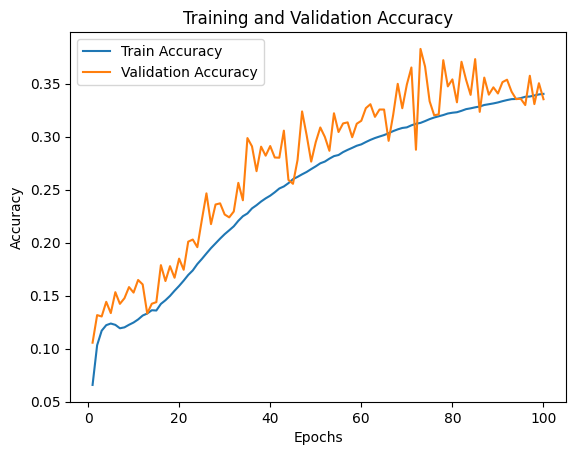

In [31]:
# Plotting the accuracy values
num_epochs=100
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracy_values, label='Train Accuracy')
plt.plot(epochs, val_accuracy_values, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

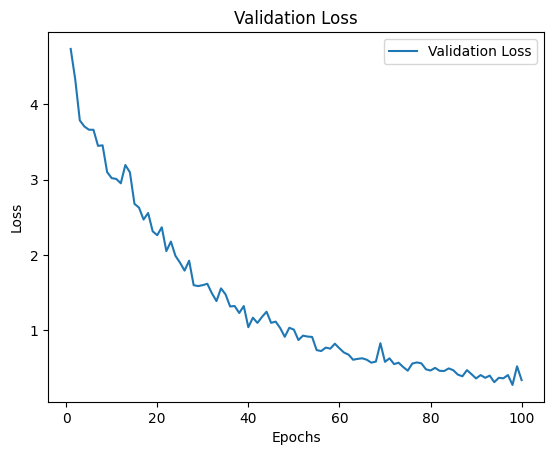

In [32]:
num_epochs = 100
epochs = range(1, num_epochs + 1)

plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

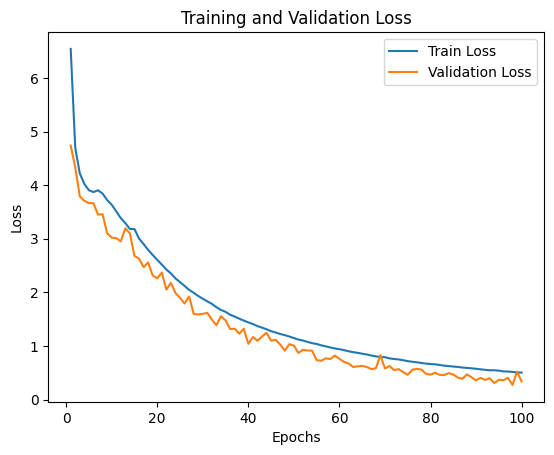

In [33]:
# Plotting the accuracy values
num_epochs=100
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_loss_values, label='Train Loss')
plt.plot(epochs, val_loss_values, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [34]:
def evaluate(image):
    temp_input = tf.expand_dims(load_image(image)[0], 0)
    img_tensor_val = image_features_extract_model(temp_input)
    img_tensor_val = tf.reshape(img_tensor_val, (img_tensor_val.shape[0], -1, img_tensor_val.shape[3]))
    start_token = tokenizer.word_index['<start>']
    end_token = tokenizer.word_index['<end>']
    decoder_input = [start_token]
    output = tf.expand_dims(decoder_input, 0) #tokens
    result = [] #word list
    attention_weights_list = []  # List to store attention weights
    for i in range(100):
        dec_mask = create_masks_decoder(output)
        predictions, attention_weights = transformer(img_tensor_val,output,False,dec_mask)
        predictions = predictions[: ,-1:, :]  # (batch_size, 1, vocab_size)
        predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)
        if predicted_id == end_token:
            return result,tf.squeeze(output, axis=0), attention_weights_list
        result.append(tokenizer.index_word[int(predicted_id)])
        output = tf.concat([output, predicted_id], axis=-1)
        # Store the attention weights for this step
        attention_weights_list.append(attention_weights)
    return result,tf.squeeze(output, axis=0), attention_weights_list

In [35]:
import matplotlib.colors as mcolors
def plot_attention(image, result, attention_plot):
    len_result = len(result)
    fig = plt.figure(figsize=(10, 10))

    for l in range(len_result):
        if l >= len(attention_plot):
            break
        
        temp_image = np.array(Image.open(image))
        temp_att = np.resize(attention_plot[l]['decoder_layer1_block1'], (8, 8))
        
        # Convert attention map to uint8 data type and apply colormap
        temp_att = (temp_att * 255).astype(np.uint8)
        temp_att = plt.get_cmap('viridis')(temp_att)[:, :, :3]  # Apply colormap (remove alpha channel)
        
        ax = fig.add_subplot(len_result//2, len_result//2, l+1)
        
        if result[l]:
            ax.set_title(str(result[l]), fontproperties=bangla_font_prop)
        else:
            ax.set_title("No Caption", fontproperties=bangla_font_prop)

        img = ax.imshow(temp_image)
        ax.imshow(temp_att, alpha=0.6, extent=img.get_extent())

    plt.tight_layout()

/kaggle/working/images/3106857210_07a92577fc.jpg
BLEU-4 score: 5.578254003710746
BLEU-3 score: 11.156508007421492
BLEU-2 score: 14.721100572393798
BLEU-1 score: 15.777684932819508
Real Caption: হলুদ রঙের জামা ও রোদচশমা পরিহিত একজন নারী রাস্তায় হাঁটছে
Predicted Caption: একজন মহিলা সমুদ্রতীরে দৌড়ায়


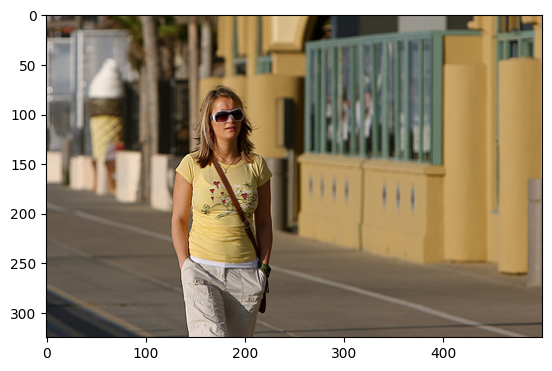

In [36]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/2144846312_d4c738dc6c.jpg
BLEU-4 score: 10.735389901075512
BLEU-3 score: 28.4031719055601
BLEU-2 score: 41.916638802381996
BLEU-1 score: 46.1999336994571
Real Caption: কমলা মাখা ঠোটে এক শিশু ক্যামেরার দিকে তাকাচ্ছে ।
Predicted Caption: এক ছোট বাচ্চা মুখে ঘাস নিয়ে চিবোচ্ছে


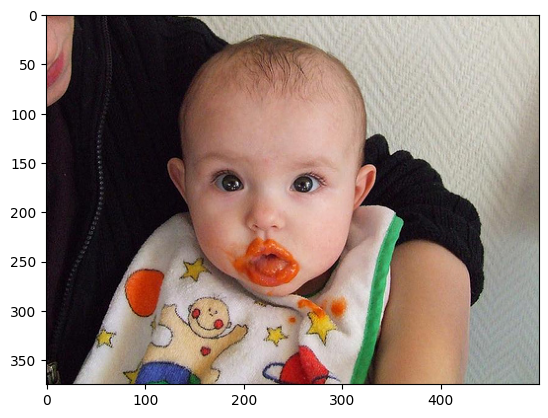

In [37]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/950273886_88c324e663.jpg
BLEU-4 score: 10.000000000000002
BLEU-3 score: 31.6227766016838
BLEU-2 score: 50.11872336272724
BLEU-1 score: 56.23413251903491
Real Caption: লাল শার্টে রক ক্লিফ আরোহী মানুষ
Predicted Caption: লাল জামা হেলমেট পরা এক ব্যক্তি একটি পাথুরে চূড়ায় উঠছে।


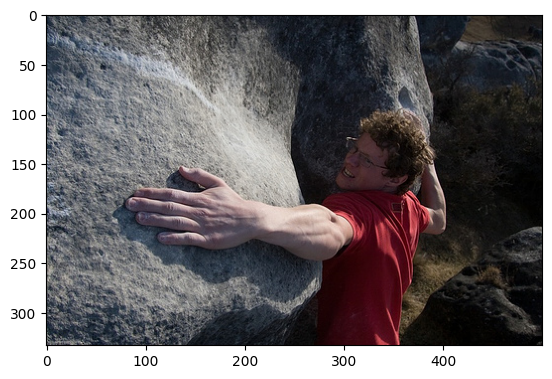

In [38]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/445861800_75fc6a8c16.jpg
BLEU-4 score: 32.749230123119276
BLEU-3 score: 51.78107940302672
BLEU-2 score: 62.19551968890802
BLEU-1 score: 65.1112602664323
Real Caption: তিনজন লোক একটি শহরের ফুটপাতে হাঁটছে
Predicted Caption: একটি দম্পতি হাঁটছে এবং নামছে।


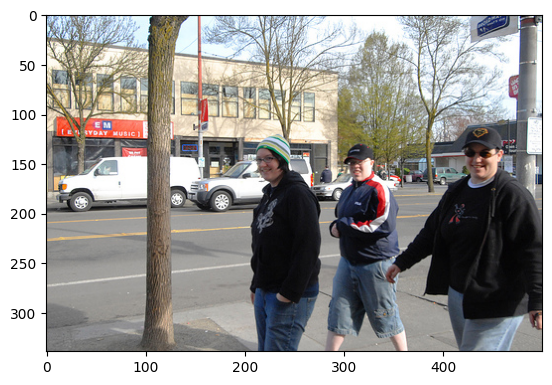

In [39]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/3443030942_f409586258.jpg
BLEU-4 score: 0
BLEU-3 score: 0
BLEU-2 score: 0
BLEU-1 score: 0
Real Caption: সাদা কালো এবং লাল রঙের কোটের একটি ব্যক্তি একটি ঢালুতে স্কিই করছে
Predicted Caption: একজন মানুষ নিচের দ্রুত ঝুলে আছে।


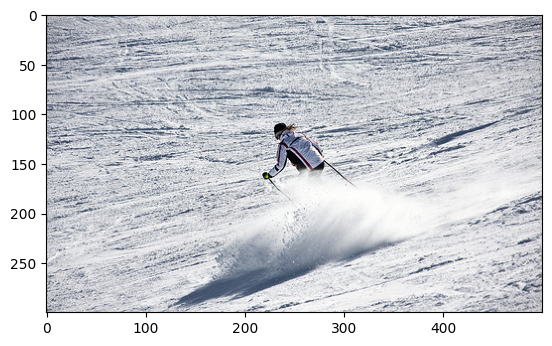

In [40]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/3184891327_8785194e3c.jpg
BLEU-4 score: 28.496906152442424
BLEU-3 score: 42.74535922866364
BLEU-2 score: 50.27192029911277
BLEU-1 score: 52.35215949109693
Real Caption: গোলাপি ও নীল জার্সি এর দুটি দলের মধ্যে একটি ফুটবল গেম অনুষ্ঠিত হচ্ছে
Predicted Caption: নীল ও সাদা পোশাক পরা দুটি মেয়ে ফুটবল খেলছে


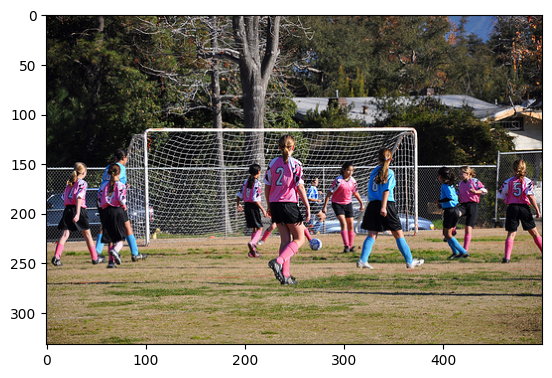

In [41]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/221973402_ecb1cd51f1.jpg
BLEU-4 score: 10.10884432854389
BLEU-3 score: 24.761510494160163
BLEU-2 score: 35.43295591860651
BLEU-1 score: 38.75385825373295
Real Caption: একটি ফ্রিসবিযুক্ত একটি কুকুর মাঠে ছেলের পিছনে তাড়া করছে।
Predicted Caption: একটি ছেলে ফুটবল কুকুরের সাথে চলছে


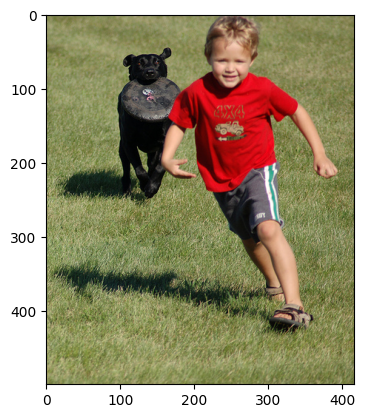

In [42]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/566794440_f9ec673a2f.jpg
BLEU-4 score: 0
BLEU-3 score: 0
BLEU-2 score: 0
BLEU-1 score: 0
Real Caption: দুইজন নারী বেসবল খেলার দস্তানা হাতে নিয়ে বেসবল মাঠ দিয়ে হেঁটে যাচ্ছে
Predicted Caption: তিনজন পোশাক পরে বারকেট বল খেলছে


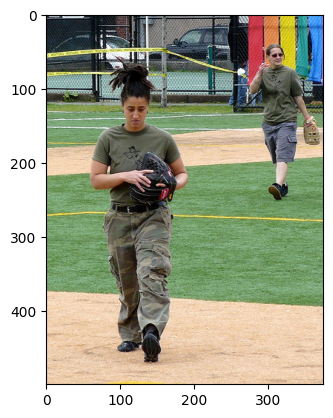

In [43]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/96978713_775d66a18d.jpg
BLEU-4 score: 0
BLEU-3 score: 0
BLEU-2 score: 0
BLEU-1 score: 0
Real Caption: লোকে পাথুরে স্রোতের উপর দিয়ে দড়ি ব্রিজ পেরিয়ে যায়।
Predicted Caption: কিছু লোক একটি নদীর উপরে


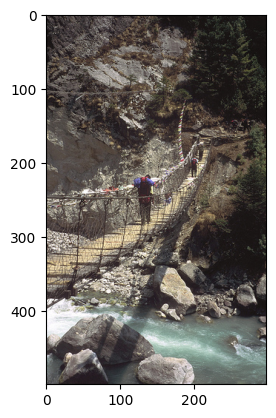

In [44]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/2978394277_4572967b97.jpg
BLEU-4 score: 39.77063630286087
BLEU-3 score: 59.655954454291305
BLEU-2 score: 70.16011660237938
BLEU-1 score: 73.0633242658635
Real Caption: খড়ের ছিটে থেকে কমলা রঙের জামা পরিহিত ছেলেটি লাফ দিয়েছে
Predicted Caption: লাল জামা পরা ছেলেটি খড়ের গাদা থেকে লাফ দিলো


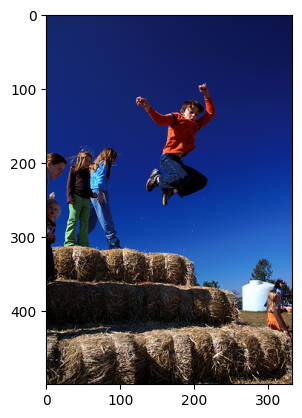

In [45]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

/kaggle/working/images/3351667846_ac43118ae5.jpg
BLEU-4 score: 7.961459006375435
BLEU-3 score: 23.88437701912631
BLEU-2 score: 37.0648647628569
BLEU-1 score: 41.36895450425725
Real Caption: পাঁচ জন লোক একটি ছোট্ট হোম রেস্তোঁরা থেকে এক প্লেট ভাত পাচ্ছেন
Predicted Caption: এক ব্যক্তি হলুদ ও হলুদ শূন্যে দোলনা বাজাচ্ছে ।


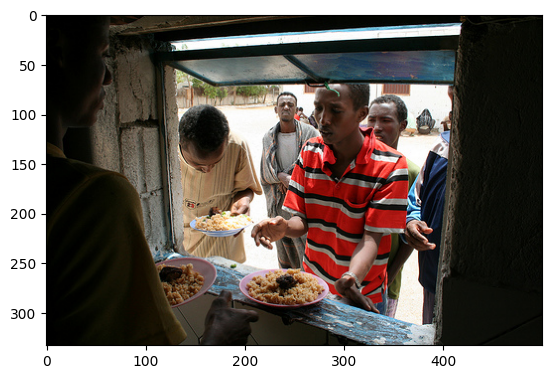

In [46]:
rid = np.random.randint(0, len(img_name_val))
image = img_name_val[rid]
print(image)
real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[rid] if i not in [0]])
caption,result,attention_plot = evaluate(image)

first = real_caption.split(' ', 1)[1]
real_caption = first.rsplit(' ', 1)[0]

for i in caption:
    if i=="<unk>":
        caption.remove(i)

for i in real_caption:
    if i=="<unk>":
        real_caption.remove(i)

result_join = ' '.join(caption)
result_final = result_join.rsplit(' ', 1)[0]
real_appn = []
real_appn.append(real_caption.split())
reference = real_appn
candidate = caption

score = sentence_bleu(reference, candidate, weights=(1.0,0,0,0))
print(f"BLEU-4 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.5,0.5,0,0))
print(f"BLEU-3 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.3,0.3,0.3,0))
print(f"BLEU-2 score: {score*100}")
score = sentence_bleu(reference, candidate, weights=(0.25,0.25,0.25,0.25))
print(f"BLEU-1 score: {score*100}")
print ('Real Caption:', real_caption)
print ('Predicted Caption:', ' '.join(caption))
temp_image = np.array(Image.open(image))
plt.imshow(temp_image)

In [47]:
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-gj2xehsb
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-gj2xehsb
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 427.8/427.8 kB 9.4 MB/s eta 0:00:00
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312246 sha256=decc411a331e08d4b914ffe80d2abb67ff2555f7675c4687b900dee0425b1ec6
  Stored in directory: /tmp/pip-ephem-wheel-cache-dz4xpy5i/wheels/43/54/73/3e2c6d4ace7657958cde52ac6fd47b342cd4aae5a7aa4fcbf9
Successfully built pycocoevalcap


In [48]:
!pip install pycocoevalcap

In [49]:
data_ref = []
data_gen = []
cnt = 0

for j in range(len(img_name_val)):
    image = img_name_val[j]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[j] if i not in [0]])
    caption, result, attention_plot = evaluate(image)
    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    for i in caption:
        if i == "<unk>":
            caption.remove(i)

    for i in real_caption:
        if i == "<unk>":
            real_caption.remove(i)

    result_join = ' '.join(caption)
    result_final = result_join.rsplit(' ', 1)[0]
    real_appn = []
    real_appn.append(real_caption.split())
    reference = real_appn
    candidate = caption

    # Convert the list to a string
    reference = ' '.join([' '.join(lst) for lst in reference])
    # Convert the list of words to a space-separated string
    candidate = ' '.join(candidate)

    if len(candidate.split()) > 25 or len(reference.split()) > 25:
        continue

    data_ref.append(reference)
    data_gen.append(candidate)
    cnt += 1

print("cnt----", cnt)

# Specify the file name
file_name1 = "convt_reference.txt"

# Create and write data from the list to the text file in the working directory
with open(file_name1, "w") as file:
    for item in data_ref:
        file.write(item + "\n")

print(f"Data from the list written to {file_name1} successfully.")

file_name2 = "convt_candidate.txt"

# Create and write data from the list to the text file in the working directory
with open(file_name2, "w") as file:
    for item in data_gen:
        file.write(item + "\n")

print(f"Data from the list written to {file_name2} successfully.")

import nltk
from nltk.util import ngrams
import numpy as np

cider_value = []
cnt = 0

for j in range(len(img_name_val)):
    image = img_name_val[j]
    real_caption = ' '.join([tokenizer.index_word[i] for i in cap_val[j] if i not in [0]])
    caption, result, attention_plot = evaluate(image)
    first = real_caption.split(' ', 1)[1]
    real_caption = first.rsplit(' ', 1)[0]

    caption = [word for word in caption if word != "<unk>"]
    real_caption = [word for word in real_caption.split() if word != "<unk>"]

    # Handle repetition in the generated caption
    caption = [w for i, w in enumerate(caption) if i == 0 or w != caption[i - 1]]

    # Truncate if the caption is too long
    max_length = 25
    if len(caption) > max_length:
        caption = caption[:max_length]

    reference_caption = ' '.join(real_caption)
    generated_caption = ' '.join(caption)

    # Tokenize the captions
    reference_tokens = nltk.word_tokenize(reference_caption)
    generated_tokens = nltk.word_tokenize(generated_caption)

    n = 4

    # Ensure n-grams calculation even for short captions
    reference_ngrams = list(ngrams(reference_tokens, n)) if len(reference_tokens) >= n else []
    generated_ngrams = list(ngrams(generated_tokens, n)) if len(generated_tokens) >= n else []

    # Calculate CIDEr score
    if reference_ngrams and generated_ngrams:
        intersection_ngram_count = len(set(reference_ngrams) & set(generated_ngrams))
        reference_ngram_count = len(reference_ngrams)
        generated_ngram_count = len(generated_ngrams)

        cider_score = intersection_ngram_count / (generated_ngram_count * reference_ngram_count) ** 0.5

        if cider_score >= 0.25:
            cider_value.append(cider_score)
            cnt += 1

sum_cider = sum(cider_value)

if cnt > 0:
    print(f"Average CIDEr score: {sum_cider / cnt}")
else:
    print("No valid captions found.")

cnt---- 766
Data from the list written to convt_reference.txt successfully.
Data from the list written to convt_candidate.txt successfully.
Average CIDEr score: 0.6924500897298753
